In [2]:
from pprint import pprint

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch

import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 500

%matplotlib inline
df_clients = pd.read_csv('data/clients.csv', index_col='client_id')
df_train = pd.read_csv('data/uplift_train.csv', index_col='client_id')
df_test = pd.read_csv('data/uplift_test.csv', index_col='client_id')


df_features = df_clients.copy()
df_features['first_issue_time'] = \
    (pd.to_datetime(df_features['first_issue_date'])
     - pd.to_datetime(df_features['first_issue_date']).min()) / pd.Timedelta('365d')

df_features['first_redeem_time'] = \
    (pd.to_datetime(df_features['first_redeem_date'])
     - pd.to_datetime(df_features['first_redeem_date']).min()) / pd.Timedelta('365d')

df_features['issue_redeem_delay'] = df_features['first_redeem_time'] \
    - df_features['first_issue_time']

df_features = df_features.join(pd.get_dummies(df_features['gender']))
df_features['first_redeem_time'] = df_features['first_redeem_time'].fillna(df_features['first_redeem_time'].mean())
df_features['issue_redeem_delay'] = df_features['issue_redeem_delay'].fillna(df_features['issue_redeem_delay'].mean())

df_features = df_features.drop(['first_issue_date', 'first_redeem_date', 'gender'], axis=1)

indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)


X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment_flg']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment_flg']

X_train_full = df_features.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment_flg']

X_test = df_features.loc[indices_test, :]

cat_features = ['gender']

In [48]:
df = pd.read_csv('data/Kuusito.csv')
df.drop(['customer_type'], axis=1, inplace=True)

df = df.replace(r'Value', '', regex=True)
df['target_control'] = df['target_control'].map({'control': 0, 'target': 1})
df['outcome'] = df['outcome'].map({'negative': 0, 'positive': 1})

# df = pd.get_dummies(df)

X = df.drop('outcome', axis=1).astype('int64')
y = df['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

treat_train = X_train['target_control']
treat_test = X_test['target_control']

X_train.drop(['target_control'], axis=1, inplace=True)
X_test.drop(['target_control'], axis=1, inplace=True)

In [49]:
from torch.utils.data import Dataset, DataLoader

class X5Dataset(Dataset):

    def __init__(self, data, target=None, treatment=None):
        super(X5Dataset, self).__init__()
        self.data = torch.from_numpy(data.values).type(torch.FloatTensor)
        if target is not None:
            self.target = torch.from_numpy(target.values).type(torch.FloatTensor)
        if treatment is not None:
            self.treatment = torch.from_numpy(treatment.values).type(torch.FloatTensor)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        m0 = torch.zeros((1, self.data.shape[1] + 1))
        m0[:, :-1] = self.data[idx, :]
        m0[:, -1] = 0
        m1 = torch.zeros((1, self.data.shape[1] + 1))
        m1[:, :-1] = self.data[idx, :]
        m1[:, -1] = 1

        if self.target is None:
            return m0.squeeze().to(device), m1.squeeze().to(device)
        else:
            return (m0.squeeze().to(device), m1.squeeze().to(device), 
                    self.target[idx].to(device), self.treatment[idx].to(device))

In [50]:
train_dataset = X5Dataset(X_train, y_train, treat_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = X5Dataset(X_test, y_test, treat_test)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [64]:
import torch
import torch.nn as nn

#class SMITEEncoder(nn.Model):

#    def __init__(self, input_dim, hidden_dims):
#        super(SMITEEncoder, self).__init__()
#        self.net = 

#    def init_base_network(self, dims):
#        layers = []
#        for i in range(len(dims) - 1):
#            layers.append(nn.Linear(dims[i], dims[i+1]))
#            layers.append(nn.ReLU())
#        return nn.Sequential(*layers[:-1])

p = 0.5


def loss_function(y_true, preds0, preds1, alpha, T, p):
    z = y_true * (T - p) / (p * (1 - p))
    vec = (z - preds1 + preds0)
    J = vec.matmul(vec) / len(vec)
    
#     P1 = preds1 / (preds0 + preds1)
#     P0 = (1 - preds1) / ((1 - preds0) + (1 - preds1))
#     P = y_true * P1 + (1 - y_true) * P0
#     I =  nn.functional.binary_cross_entropy(P, T)
    
    preds = T * preds1 + (1 - T) * preds0
    L = nn.functional.binary_cross_entropy(preds, y_true)
    return alpha * L + (1 - alpha) * J

input_dim = 21
# hidden_dims = [256, 256, 256, 256, 256, 256, 256]
hidden_dims = [256, 256]

dims = [input_dim] + hidden_dims + [1]

layers = []
for i in range(len(dims) - 1):
    layers.append(nn.Linear(dims[i], dims[i+1]))
    layers.append(nn.ReLU())
layers[-1] = nn.Sigmoid()
model = nn.Sequential(*layers).to(device)

In [65]:
optimizer = torch.optim.Adam(model.parameters(), 0.003)

In [66]:
N_EPOCHS = 100
alpha = 0.5
p = 0.5

for i in range(N_EPOCHS):

    loss_train = []

    for data0, data1, target, treat in train_loader:
        
        preds0 = model(data0).squeeze()
        preds1 = model(data1).squeeze()
        loss = loss_function(target, preds0, preds1, alpha, treat, p)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_train.append(loss.item())
    loss_train = np.mean(loss_train)

    labels_val = []
    preds_val = []
    loss_val = []
    for data0, data1, target, treat in val_loader:
        labels_val += list(target)
        preds0 = model(data0).squeeze()
        preds1 = model(data1).squeeze()
        loss = loss_function(target, preds0, preds1, alpha, treat, p)
        preds_val += list(preds1 - preds0)
        loss_val.append(loss.item())

    accuracy = (np.array(preds_val).astype(np.int16) == np.array(labels_val)).sum() / len(preds_val)
    print(f'Epoch {i} \t Loss train {loss_train:.4f} \t Accuracy test {accuracy:4f} \t Loss test {np.mean(loss_val):.4f}')

Epoch 0 	 Loss train 25.0313 	 Accuracy test 0.496364 	 Loss test 25.7844
Epoch 1 	 Loss train 26.4889 	 Accuracy test 0.496364 	 Loss test 25.7563
Epoch 2 	 Loss train 26.3520 	 Accuracy test 0.496364 	 Loss test 25.3934
Epoch 3 	 Loss train 24.4155 	 Accuracy test 0.496364 	 Loss test 26.0104
Epoch 4 	 Loss train 25.3019 	 Accuracy test 0.496364 	 Loss test 26.0171
Epoch 5 	 Loss train 25.3314 	 Accuracy test 0.496364 	 Loss test 25.9823
Epoch 6 	 Loss train 25.3379 	 Accuracy test 0.496364 	 Loss test 25.9362
Epoch 7 	 Loss train 25.0637 	 Accuracy test 0.496364 	 Loss test 25.2624
Epoch 8 	 Loss train 25.6335 	 Accuracy test 0.496364 	 Loss test 25.7841
Epoch 9 	 Loss train 26.3556 	 Accuracy test 0.496364 	 Loss test 25.7565
Epoch 10 	 Loss train 26.3192 	 Accuracy test 0.496364 	 Loss test 25.7413
Epoch 11 	 Loss train 25.8099 	 Accuracy test 0.496364 	 Loss test 25.7982
Epoch 12 	 Loss train 26.3351 	 Accuracy test 0.496364 	 Loss test 25.8354
Epoch 13 	 Loss train 26.2562 	 Acc

In [67]:
from sklift.metrics import uplift_at_k

uplift = []
for data0, data1, target, treat in val_loader:
    preds0 = model(data0).squeeze()
    preds1 = model(data1).squeeze()
    uplift += list(preds1 - preds0)
score = uplift_at_k(y_true=y_test, uplift=uplift, treatment=treat_test, strategy='by_group', k=0.3)

print(f"Uplift at 30: {score}")

Uplift at 30: -0.003247443762781188


<AxesSubplot:title={'center':'Qini curve\nqini_auc_score=0.0000'}, xlabel='Number targeted', ylabel='Number of incremental outcome'>

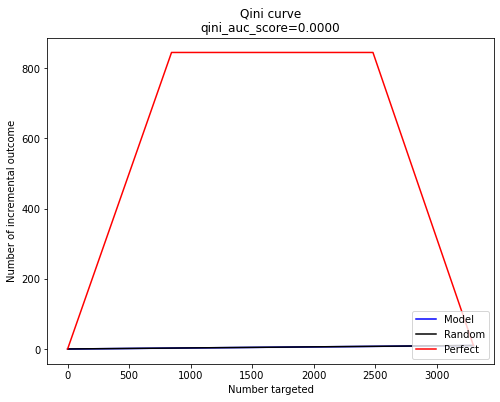

In [68]:
from sklift.viz import plot_qini_curve
plot_qini_curve(y_true=y_test, uplift=uplift, treatment=treat_test, negative_effect=True)